In [1]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
#그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

In [2]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    X_data = []
    temp = []
    global mfcc_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T

                X_data.extend(mfcc)
                #print("MFCC Size : ", len(mfcc))
    #end loop
    print("X_data :",np.shape(X_data))
    mfcc_data = X_data
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
print(np.shape(mfcc_data))

Foldername : 1 - 20 files
Filename : Ryu1.wav
Filename : Ryu10.wav
Filename : Ryu11.wav
Filename : Ryu12.wav
Filename : Ryu13.wav
Filename : Ryu14.wav
Filename : Ryu15.wav
Filename : Ryu16.wav
Filename : Ryu17.wav
Filename : Ryu18.wav
Filename : Ryu19.wav
Filename : Ryu2.wav
Filename : Ryu20.wav
Filename : Ryu3.wav
Filename : Ryu4.wav
Filename : Ryu5.wav
Filename : Ryu6.wav
Filename : Ryu7.wav
Filename : Ryu8.wav
Filename : Ryu9.wav
X_data : (14956, 45)
(14956, 45)


In [3]:
def make_data(data):
    a = []
    for j, row in enumerate(data):
        if(j+500 == len(data)):
            a = np.array(a)
            return a
        a.append(data[j:j+500])

X_train = make_data(mfcc_data)

In [4]:
print(X_train.shape)

(14456, 500, 45)


In [5]:
X_train = X_train.reshape(14456,22500)
print(X_train.shape)
X_train[0].shape

(14456, 22500)


(22500,)

In [6]:
generator = Sequential([                 #generator 시퀀스 생성 
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(22500, activation='tanh'),
])

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 22500)             2

In [8]:
discriminator = Sequential([
    Dense(1024, input_shape=(22500,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), #relu의 개선버전
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              23041024  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [11]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [12]:
gan = Model(gan_input, output)
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 22500)             23722212  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 23697409  
Total params: 47,419,621
Trainable params: 23,722,212
Non-trainable params: 23,697,409
_________________________________________________________________


In [13]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [14]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    #오디오 파일 듣기 추가 요망

In [15]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [16]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

BATCH_SIZE = 128
EPOCHS= 50

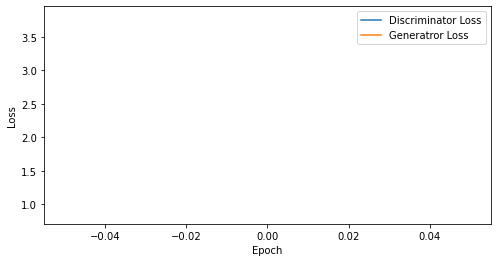

epoch: 1, Discriminator Loss: 3.809654712677002, Generator Loss: 0.859234631061554


KeyboardInterrupt: 

In [17]:
for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_sounds in get_batches(X_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_sounds = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_sounds, generated_sounds])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)